In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

Most dynamic equilbrium models in economics do not have closed form solutions.  Instead, numerical methods are used to approximate their behavior. Here I show how Deep-Q Learning with a Natural Advantage Function can be used to approximate the solution to dynamic equilibrium models.

First, I review the neoclassical growth model.  Then I show how to solve the model using the Value Iteration Approach.  Finally, I show how to solve the model using Deep-Q Learning with the Natural Advantage Function.  In the future, I'll compare the accuracy of the Deep-Q Learning to Peturbation Methods and the Value Iteration Approach on more complicated models.

Useful background material is "Comparing Solution Methods for Dynamic Equilibrium Economies" (https://www.econstor.eu/bitstream/10419/100716/1/wp2003-27.pdf) which describes the relative accuracy existing numerical solution methods.  "Continuous Deep Q-Learning with Model-based Acceleration" (https://arxiv.org/pdf/1603.00748.pdf) introduces the Natural Advantage function.

## The Neoclassical Model

The neoclassical growth model was introduced in the 40s to describe long-term growth of economies. It involves a planner for the economy.  The planner faces a bread vs butter problem. She has some capital today.  She needs to decide how much capital society should consume today vs how much capital she should invest so people can consume tomorrow.

The two building blocks are the utility function: how happy society is from consuming $c_t$.  And the production function, how much can society produce given capital $k_t$section

Given capital $k_t$ in period $t$, society can produce $z_tk_t^{\alpha}$ capital the next period.  Where $\alpha < 1$, there are diminishing returns. And there is a technology $z_t>0$.  Capital deprecates at rate $\delta$. Therefore the production function looks like

$$z_tk_t^{\alpha} + (1- \delta)k_t$$

The utility function is the $\log$ of consumption, eg there are diminishing returns to consuming.  In more complicated models there would also be leisure and a return on leisure.  Putting these building blocks together the planners problem looks like

$$ \max_{c_t, k_{t+1}} \mathbb{E} \sum_{t=0}^{\inf} (1-\beta)\beta^t \log{c_t}$$

subject to

$$c_t + k_{t+1} = z_tk_t^{\alpha} + (1- \delta)k_t$$ 

The planners problem is to choose $c_t$ and $k_{t+1}$ to maximize utility. 

What makes this an RBC problem is that we hav productivity shocks. So the $z_t$ is stochastic.

# Value Iteration Approach

Aruoba and Fernández-Villaverde solve the problem using the Value Iteration Approach here https://github.com/jesusfv/Comparison-Programming-Languages-Economics/blob/master/RBC_Python.py

The difficulty in useing the "Value Iteration Method" is that the state space and decision spaces are continious.  But value itearation is discrete.  The most straightforward approach reproduced below is to just discretize the space.  That approach is the most accurate.  But also doesn't scale computationally, the complexity increases exponentially with the complexity of the state space. 

The code is reproduced below.  First, we define the dynamics of the economy.

In [2]:
import numpy as np

aalpha = 1.0/3.0     # Elasticity of output w.r.t. capital
bbeta  = 0.95        # Discount factor

# Productivity values
vProductivity = np.array([0.9792, 0.9896, 1.0000, 1.0106, 1.0212],float)

# Transition matrix
mTransition = np.array([[0.9727, 0.0273, 0.0000, 0.0000, 0.0000],
                     [0.0041, 0.9806, 0.0153, 0.0000, 0.0000],
                     [0.0000, 0.0082, 0.9837, 0.0082, 0.0000],
                     [0.0000, 0.0000, 0.0153, 0.9806, 0.0041],
                     [0.0000, 0.0000, 0.0000, 0.0273, 0.9727]],float)

Then we reproduce the grids used to solve solve the problem.

In [3]:
capitalSteadyState     = (aalpha*bbeta)**(1/(1-aalpha))
outputSteadyState      = capitalSteadyState**aalpha
consumptionSteadyState = outputSteadyState-capitalSteadyState

# We generate the grid of capital
vGridCapital           = np.arange(0.5*capitalSteadyState,1.5*capitalSteadyState,0.00001)

nGridCapital           = len(vGridCapital)
nGridProductivity      = len(vProductivity)

## 3. Required matrices and vectors

mOutput           = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mValueFunction    = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mValueFunctionNew = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mPolicyFunction   = np.zeros((nGridCapital,nGridProductivity),dtype=float)
expectedValueFunction = np.zeros((nGridCapital,nGridProductivity),dtype=float)

 # 4. We pre-build output for each point in the grid

for nProductivity in range(nGridProductivity):
    mOutput[:,nProductivity] = vProductivity[nProductivity]*(vGridCapital**aalpha)

print("Output = ", outputSteadyState, " Steady State Capital = ", capitalSteadyState, "  Steady State Consumption = ", consumptionSteadyState)
print("len vGridCapital", nGridCapital, "dim mPolicyFunction", mPolicyFunction.shape)


Output =  0.5627314338711378  Steady State Capital =  0.178198287392527   Steady State Consumption =  0.3845331464786108
len vGridCapital 17820 dim mPolicyFunction (17820, 5)


In [4]:
import math
import time

t1=time.time()

maxDifference = 10.0
tolerance = 0.0000001
iteration = 0

log = math.log
zeros = np.zeros
dot = np.dot

while(maxDifference > tolerance):
    expectedValueFunction = dot(mValueFunction,mTransition.T)

    for nProductivity in range(nGridProductivity):

        # We start from previous choice (monotonicity of policy function)
        gridCapitalNextPeriod = 0

        for nCapital in range(nGridCapital):

            valueHighSoFar = -100000.0
            capitalChoice  = vGridCapital[0]

            for nCapitalNextPeriod in range(gridCapitalNextPeriod,nGridCapital):
                consumption = mOutput[nCapital,nProductivity] - vGridCapital[nCapitalNextPeriod]
                valueProvisional = (1-bbeta)*log(consumption)+bbeta*expectedValueFunction[nCapitalNextPeriod,nProductivity];

                if valueProvisional>valueHighSoFar:
                    valueHighSoFar = valueProvisional
                    capitalChoice = vGridCapital[nCapitalNextPeriod]
                    gridCapitalNextPeriod = nCapitalNextPeriod
                else:
                    break # We break when we have achieved the max


            mValueFunctionNew[nCapital,nProductivity] = valueHighSoFar
            mPolicyFunction[nCapital,nProductivity]   = capitalChoice

    maxDifference = (abs(mValueFunctionNew-mValueFunction)).max()

    mValueFunction    = mValueFunctionNew
    mValueFunctionNew = zeros((nGridCapital,nGridProductivity),dtype=float)

    iteration += 1
    if(iteration%10 == 0 or iteration == 1):
        print(" Iteration = ", iteration, ", Sup Diff = ", maxDifference)
        
print(" Iteration = ", iter, ", Sup Duff = ", maxDifference)
print(" ")
print(" My Check = ", mPolicyFunction[1000-1,3-1])
print(" ")

t2 = time.time()

print("Elapse time = is ", t2-t1)

 Iteration =  1 , Sup Diff =  0.05274159340733661
 Iteration =  10 , Sup Diff =  0.031346949265852186
 Iteration =  20 , Sup Diff =  0.0187034598933572
 Iteration =  30 , Sup Diff =  0.01116551203397076
 Iteration =  40 , Sup Diff =  0.006668541708132469
 Iteration =  50 , Sup Diff =  0.003984292748717144
 Iteration =  60 , Sup Diff =  0.0023813118039327508
 Iteration =  70 , Sup Diff =  0.0014236586450981914
 Iteration =  80 , Sup Diff =  0.0008513397747206275
 Iteration =  90 , Sup Diff =  0.0005092051752288995
 Iteration =  100 , Sup Diff =  0.00030462324421465237
 Iteration =  110 , Sup Diff =  0.00018226485632311107
 Iteration =  120 , Sup Diff =  0.00010906950872624499
 Iteration =  130 , Sup Diff =  6.527643736298216e-05
 Iteration =  140 , Sup Diff =  3.907108211997912e-05
 Iteration =  150 , Sup Diff =  2.338807712021218e-05
 Iteration =  160 , Sup Diff =  1.400864463707574e-05
 Iteration =  170 , Sup Diff =  8.391317202871562e-06
 Iteration =  180 , Sup Diff =  5.026474537928

Note "My Check" compares the solution of a particular location in the grid to the closed form solution when delta=1.

# Non-grid Based Solutions

Historically economists have used "projection methods" to solve for sparsity.  They approximate the funcion using Chebyshev polynomials and then solve for the coeffeients that minimize the Bellman errors.

Of course neural networks are much universal function approximaters than Chebyshev polynomials.  We should try to do that instead!

There are two papers that do so

[Deep Reinforcement Learning in Macroeconomics, Atashbar and Shi 2023](https://www.imf.org/-/media/Files/Publications/WP/2023/English/wpiea2023040-print-pdf.ashx&ved=2ahUKEwizrvS3upeNAxVIBTQIHU_HEvIQFnoECA0QAQ&usg=AOvVaw0LcQOIlCBsYHU0U4V3bUU0)

Use reinforcement learning techniques like DDPG to solve RBC models

["Solving high-dimensional dynamic stochastic models using deep learning"](https://maximilianvogler.github.io/My_Website/Deep_Learning.pdf)

Use value iteration on the ergodic set including the Bellman Error in the loss to solve RBC models.

But I think both of these approaches are too complicated! And that plain value iteration with neural approximaters will suffice

In [5]:
import matplotlib.pyplot as plt

def q(expectedValueFunction, nCapital, nProductivity, nCapitalNextPeriod):
    """
    Compute Q(k, z, k') = u(c) + beta * E[V(k', z')]

    Parameters:
        expectedValueFunction: precomputed E[V(k', z')]
        nCapital: index of current capital
        nProductivity: index of current productivity
        nCapitalNextPeriod: index of next-period capital choice

    Returns:
        Q value for given state and action
    """
    consumption = mOutput[nCapital,nProductivity] - vGridCapital[nCapitalNextPeriod]
    return (1-bbeta)*math.log(consumption)+bbeta*expectedValueFunction[nCapitalNextPeriod,nProductivity]

def visualize_q(mValueFunction):
    """
    Plot Q(k, z, k') for a fixed (k, z), varying over k'

    Parameters:
        mValueFunction: current value function matrix
        mOutput: output matrix precomputed over (k, z)
        vGridCapital: capital grid
        mTransition: Markov transition matrix
        bbeta: discount factor
    """
    nCapital = len(vGridCapital) // 2  # Midpoint in grid
    nProductivity = mOutput.shape[1] // 2  # Midpoint z index

    # Precompute E[V(k', z')]
    expectedValueFunction = np.dot(mValueFunction, mTransition.T)

    q_vals = []
    k_prime_vals = []

    for nCapitalNextPeriod in range(len(vGridCapital)):
        c = mOutput[nCapital, nProductivity] - vGridCapital[nCapitalNextPeriod]
        if c <= 0:
            q_val = -np.inf
        else:
            q_val = q(expectedValueFunction, nCapital, nProductivity, nCapitalNextPeriod)
        q_vals.append(q_val)
        k_prime_vals.append(vGridCapital[nCapitalNextPeriod])

    plt.figure(figsize=(8, 5))
    plt.plot(k_prime_vals, q_vals)
    plt.xlabel("Next-period capital $k'$")
    plt.ylabel("Q-value")
    plt.title(f"Q(k={vGridCapital[nCapital]:.3f}, z_index={nProductivity}) vs $k'$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


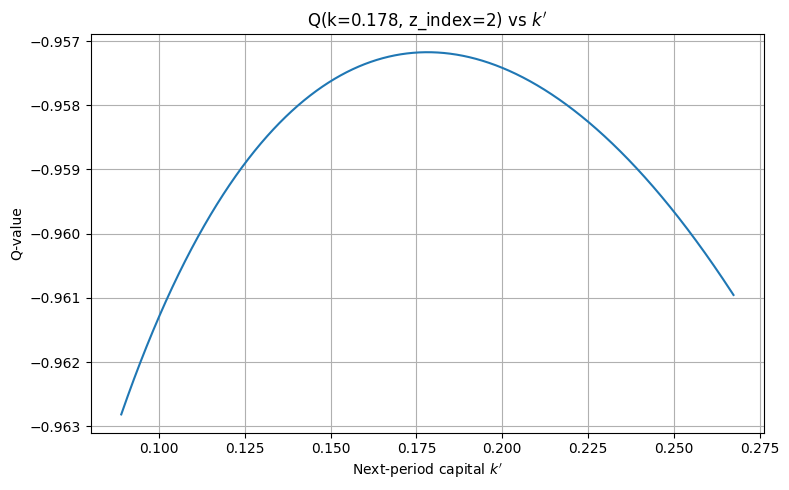

In [16]:
visualize_q(mValueFunction)

From the above we see in our example at least that the Q function is very smooth. 

(1) Compared to RL problems like Cartpole sampling states near the optimal policy is probably not very important. The policy far from the optimal is likely to generalize well to the streategy near the optimal.

(2) The value function is very flat.  While in cartpole if you make a mistake you fall off a cliff.  In RBC models you just have a small deviation from the optimum.  So the solution is likely to be thrown off if the value function is badly specified.

Another thing that is different than Cartpole is that its easy to guess if the solution is pretty good

(1) We can visualize how well the solution does when delta=1 and we have a closed form solution

(2) We can check if the Euler conditions are met

In [8]:
import train_neuralgrid

model = train_neuralgrid.main(cold_start=False, uniform_sampling=True, random_delta=False)

Step 250 completed, value_loss 0.004160600248724222 action_loss 2.1736443042755127 value error 0.2617877125740051 euler error 0.04411589883237985 euler error clipped 0.04554103014371692
Step 500 completed, value_loss 0.011002926155924797 action_loss 3.912158966064453 value error 0.1927281618118286 euler error 0.016906775556711644 euler error clipped 0.014847780248847442
Training is complete


<module 'matplotlib.pyplot' from '/home/ygreif/code/bellmansrevenge/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

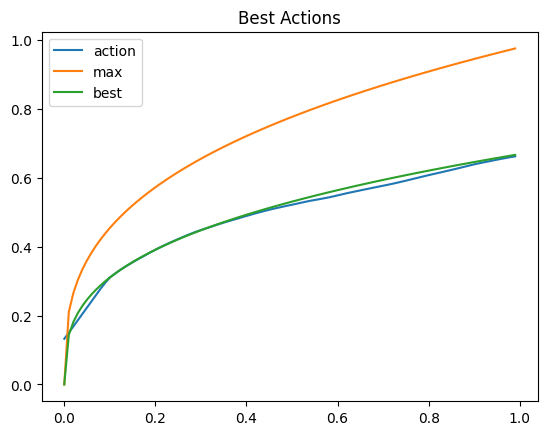

In [9]:
from qtable.q_utils import render_v_vs_target, renderBestA, renderV

renderBestA(model)
    

In reality it took some debugging.  But that was really easy!  Doing the straightforward thing yieled a Euler error of 1% and a strategy that visually looks optimal.

Training actions coldstart
0 0.32057154178619385
[0] predicted mean: 0.9933, target mean: 0.4308, loss: 0.3206
25 0.01670519821345806
[25] predicted mean: 0.5083, target mean: 0.4325, loss: 0.0167
50 0.004720158409327269
[50] predicted mean: 0.4397, target mean: 0.4294, loss: 0.0047
75 0.0009586414671503007
[75] predicted mean: 0.4369, target mean: 0.4287, loss: 0.0010


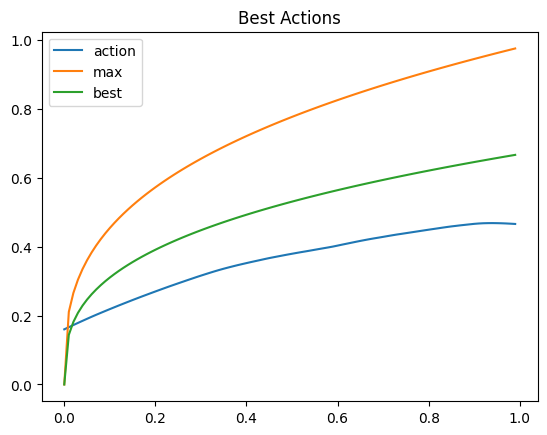

[Critic Pretraining Step 0] value loss = 0.791861
[Critic Pretraining Step 1] value loss = 0.745180
Before training, but after coldstart


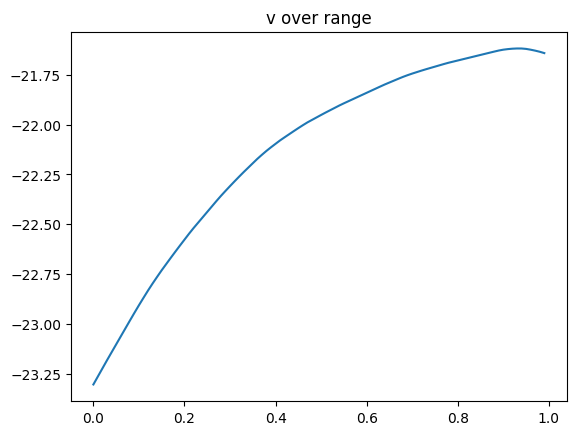

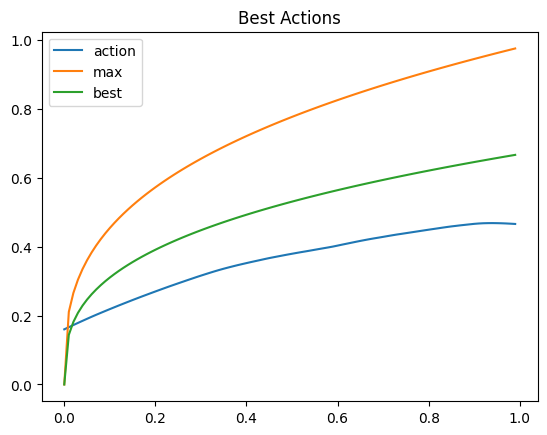

Step 0 utility -28.173577707664414
Episode 0 utility -28.173577707664414 convergence 8.466649603633414e-08 completed value error 0.041311897337436676 euler error 0.37527804135107207


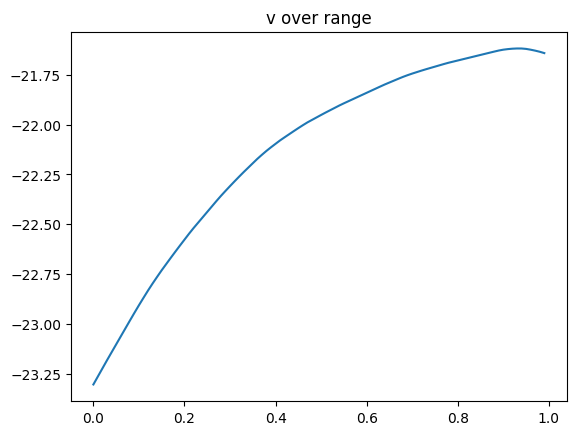

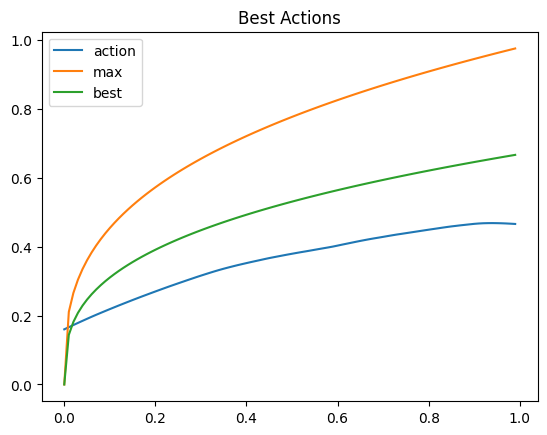

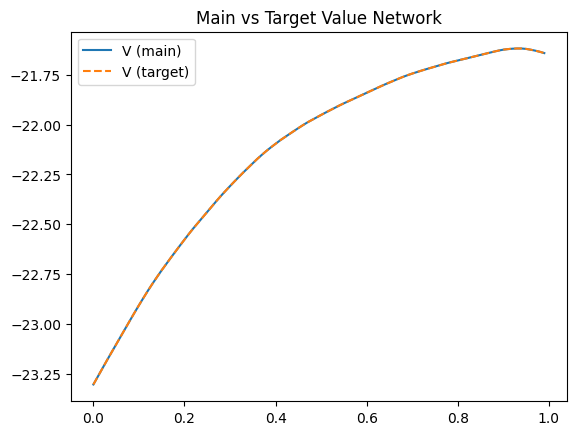

Step 10 utility -26.742229618772356
Step 20 utility -26.35383159164829
Step 30 utility -27.019479867727682
Step 40 utility -29.111032077178418
Step 50 utility -27.584304915888637
Episode 50 utility -27.584304915888637 convergence 0.024071430787444115 completed value error 0.056582480669021606 euler error 143.74671254565283


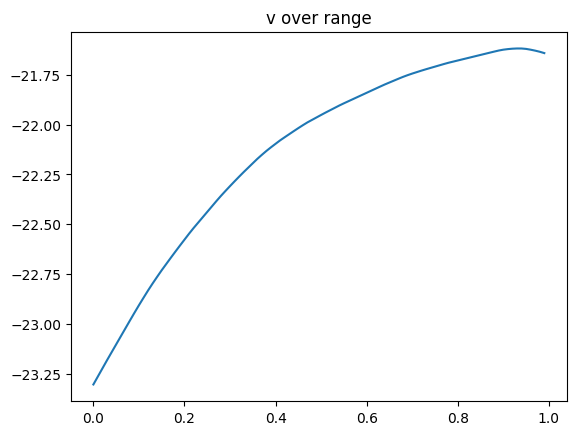

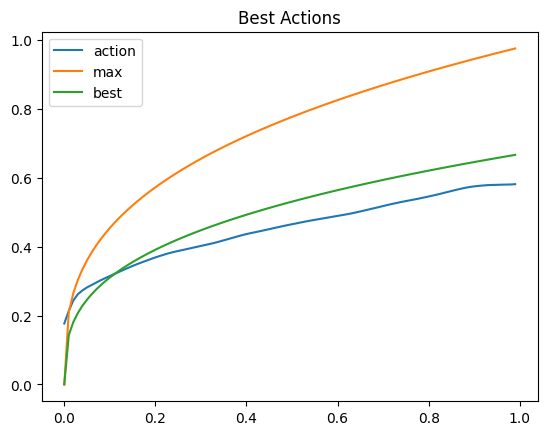

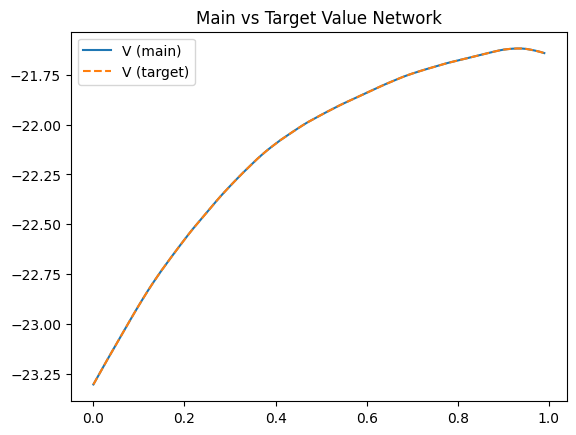

Step 60 utility -26.078174388808055
Step 70 utility -26.530382649015948
Step 80 utility -27.28829255946776
Step 90 utility -25.37349107736003
Step 100 utility -24.289489698409405
Episode 100 utility -24.289489698409405 convergence 0.017434515058994293 completed value error 0.05062365531921387 euler error 129.47362132125863


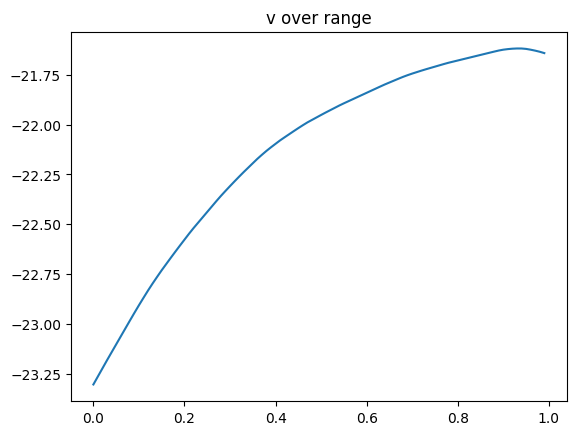

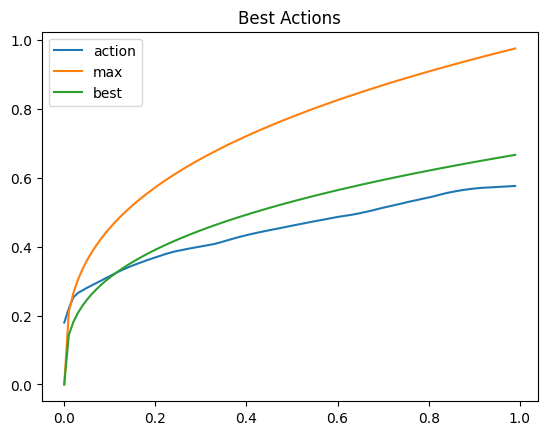

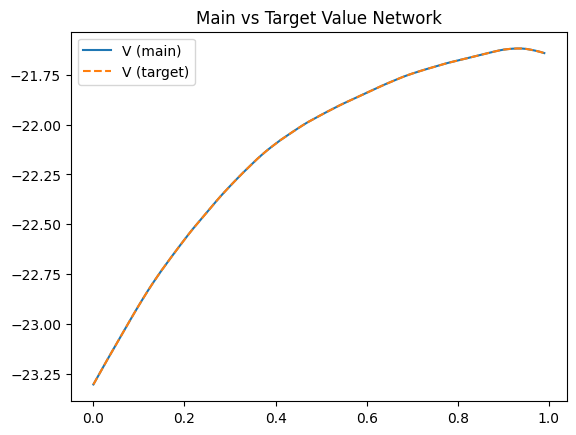

Step 110 utility -22.605594609071904
Step 120 utility -24.069017251675312
Step 130 utility -23.770195019727613
Step 140 utility -23.92782549851481
Step 150 utility -23.6723006659658
Episode 150 utility -23.6723006659658 convergence 0.011127552017569542 completed value error 0.04793849214911461 euler error 144.35605473449345


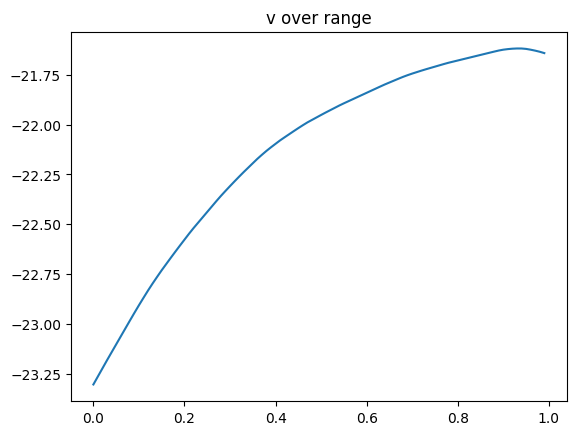

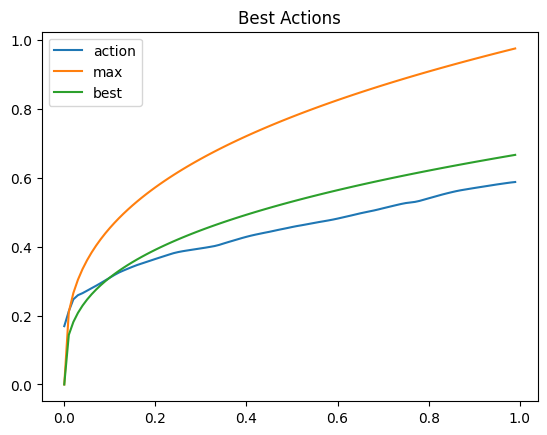

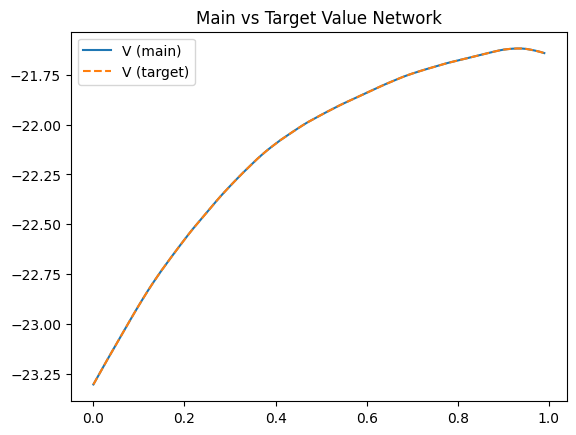

In [20]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-3,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': True}

import train_rl
model = train_rl.run(**params)

In [21]:
from policy import diagnostics
from envs.economy import jesusfv
print(diagnostics.euler_error(model, jesusfv, 30, {'k': .1, 'z': 0}, debug=True))

iter 0 eps 0.024354273103843457 k 0.1 z 0
iter 1 eps -0.055485725317564585 k 0.14439631298219974 z 0
iter 2 eps -0.1024403951467019 k 0.17483158021473888 z 0
iter 3 eps -0.12549737821423884 k 0.19406217125479674 z 0
iter 4 eps -0.13560707793532942 k 0.20500162712955194 z 0
iter 5 eps -0.14056270507842644 k 0.21067990186071095 z 0
iter 6 eps -0.14289702014308503 k 0.2135499395532382 z 0
iter 7 eps -0.1440067912794173 k 0.21496459421884329 z 0
iter 8 eps -0.14453731570136297 k 0.21565310949941996 z 0
iter 9 eps -0.1447921813982871 k 0.2159861592559661 z 0
iter 10 eps -0.14491474614604866 k 0.21614685079603857 z 0
iter 11 eps 0.763415735888538 k 0.21622426724673616 z 1
iter 12 eps 1.2935314457855864 k 0.10174424754411782 z 1
iter 13 eps 2.246899733860898 k 0.06093452339503974 z 1
iter 14 eps 8.554972448131906 k 0.03565525305384665 z 1
iter 15 eps 690.9815010175313 k 0.0104483396699801 z 2
iter 16 eps 145.66448853321978 k 9.999806599242378e-05 z 2
iter 17 eps 145.6667221419636 k 0.00010000

The visual inspection shows okay convergence.  But the Euler Error is very high! Below we can see its because eventually the policy function makes a mistake. And it enters a range where consumption is too high and the Euler Error is repeatedly too high. If we clip actions results improve. But still aren't great

In [26]:
print(diagnostics.euler_error(model, jesusfv, 100, {'k': .1, 'z': 0}, clip=False, debug=True, print_every=10))
print(diagnostics.euler_error(model, jesusfv, 100, {'k': .1, 'z': 0}, clip=True, debug=True, print_every=10))

iter 0 eps 0.024354273103843457 k 0.1 z 0
iter 10 eps 2.2546335668591997 k 0.060842028658332215 z 1
iter 20 eps 144.13436766548907 k 0.00010000087047229433 z 1
iter 30 eps 144.13969965581867 k 0.00010000272407665461 z 1
iter 40 eps 144.13386034196495 k 0.00010000021439603851 z 1
iter 50 eps 144.13654520576694 k 0.00010000071440229019 z 1
iter 60 eps 144.13649898476854 k 0.00010000022690945243 z 1
iter 70 eps 145.66841221210984 k 0.00010000338137185899 z 2
iter 80 eps 145.66739213749824 k 0.00010000085225030791 z 2
iter 90 eps 145.66431886086673 k 0.00010000294095478118 z 2
132.83533024987483
iter 0 eps 0.024354273103843457 k 0.1 z 0
iter 10 eps -0.14491474614604866 k 0.21614685079603857 z 0
iter 20 eps 5.017835520103758 k 0.03566758487169902 z 1
iter 30 eps 5.016781324301606 k 0.011006600007090861 z 1
iter 40 eps 5.016781295093381 k 0.0110063808526554 z 1
iter 50 eps 5.0167812950924535 k 0.011006380848944036 z 1
iter 60 eps 5.017336827848118 k 0.01133860676303039 z 3
iter 70 eps 5.0173

Training actions coldstart
0 0.3254193067550659
[0] predicted mean: 0.9972, target mean: 0.4300, loss: 0.3254
25 0.00029726687353104353
[25] predicted mean: 0.4440, target mean: 0.4282, loss: 0.0003
50 6.313893391052261e-05
[50] predicted mean: 0.4283, target mean: 0.4252, loss: 0.0001
75 2.8662714612437412e-05
[75] predicted mean: 0.4270, target mean: 0.4275, loss: 0.0000


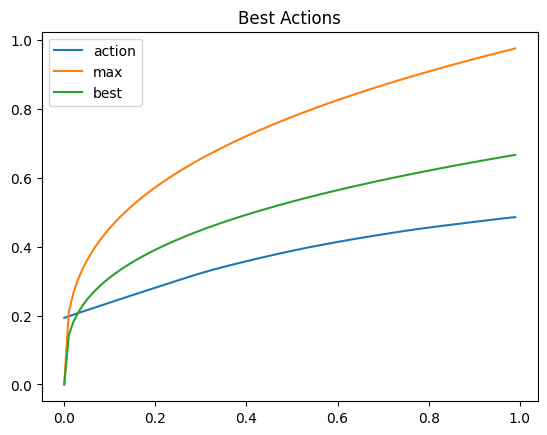

[Critic Pretraining Step 0] value loss = 0.774393
[Critic Pretraining Step 1] value loss = 0.572789
Before training, but after coldstart


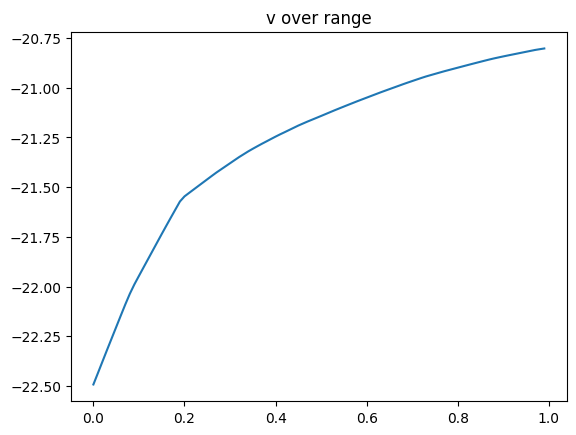

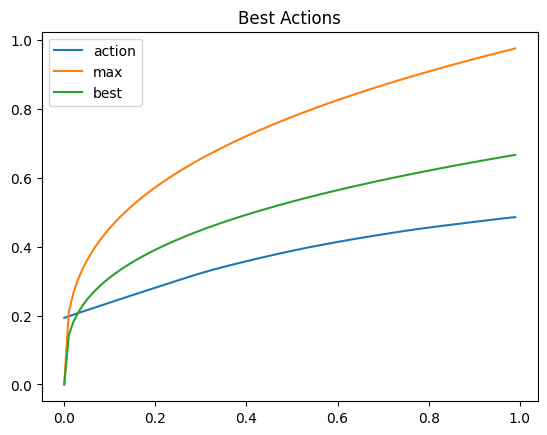

Step 0 utility -26.988249608556814
Episode 0 utility -26.988249608556814 convergence 6.825547416156041e-08 value error 0.025277074426412582 euler error 0.3697736345991813


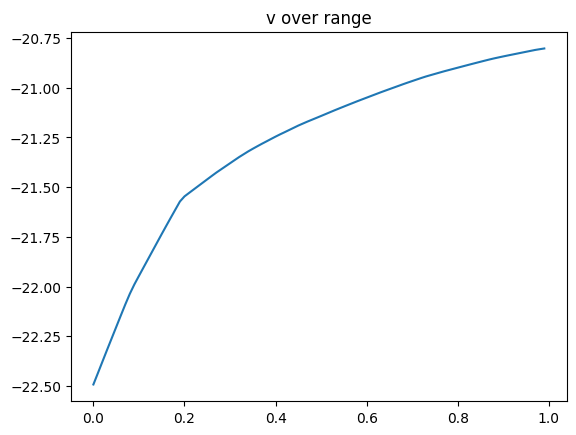

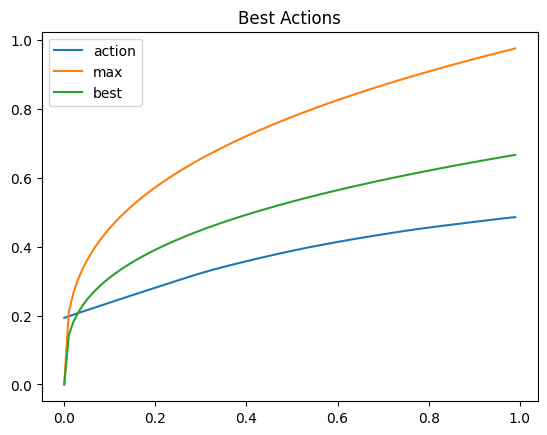

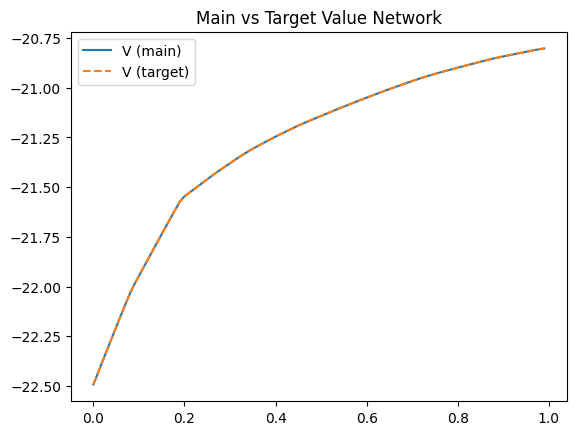

Step 10 utility -26.933392213817044
Step 20 utility -26.378267482559174
Step 30 utility -24.6508761085557
Step 40 utility -26.52248463767913
Step 50 utility -28.908129976355106
Episode 50 utility -28.908129976355106 convergence 0.028785018250346184 value error 0.041174620389938354 euler error 0.08650387715150014


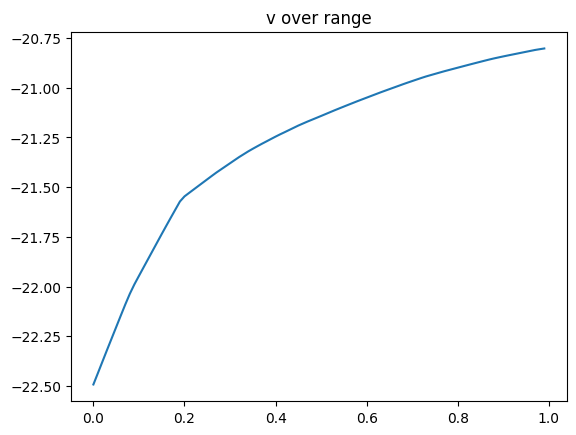

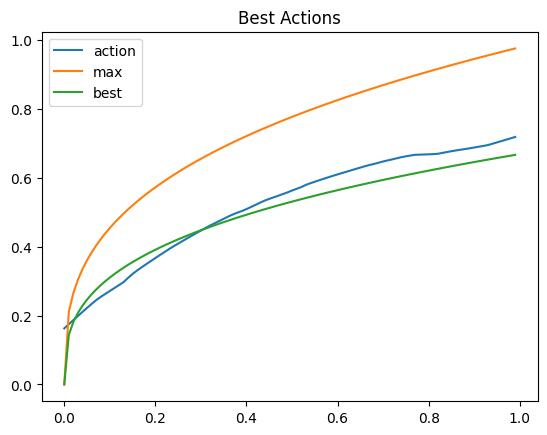

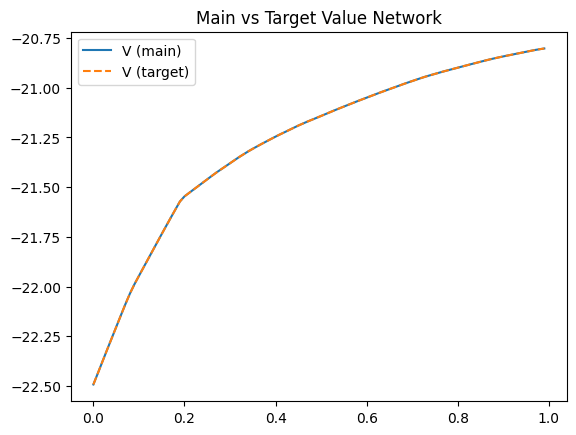

Step 60 utility -22.181732561252975
Step 70 utility -23.435265371220204


In [ ]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-2,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': True,
           'coldstart_actor': True}

import train_rl
model = train_rl.run(**params)

In [21]:
from policy import diagnostics
from envs.economy import jesusfv
print(diagnostics.euler_error(model, jesusfv, 100, {'k': .1, 'z': 0}, clip=False, debug=True))

iter 0 eps 0.07594869802845883 k 0.1 z 0
iter 1 eps 0.06876213600394351 k 0.13360387876665408 z 0
iter 2 eps 0.04676085751979984 k 0.1485597067364638 z 0
iter 3 eps 0.03883471790222441 k 0.15644380386914392 z 0
iter 4 eps 0.03603547251970826 k 0.16011594040993116 z 0
iter 5 eps 0.03440073761945247 k 0.1617230712717005 z 0
iter 6 eps 0.03364666827090097 k 0.16246881625082532 z 0
iter 7 eps 0.03330395497945166 k 0.16281348630727366 z 0
iter 8 eps 1.3556860920448184 k 0.16297195197101233 z 1
iter 9 eps 1.877921699840109 k 0.07042386598977357 z 1
iter 10 eps 6.690746857965093 k 0.042024971792381904 z 1
iter 11 eps 746.8425398617624 k 0.013607428321099513 z 1
iter 12 eps 144.13550300689099 k 9.999847576150356e-05 z 1
iter 13 eps 144.13581434242153 k 0.00010000144915991299 z 1
iter 14 eps 144.1373611851242 k 0.0001000022225044403 z 1
iter 15 eps 144.13710431504245 k 0.00010000141896674558 z 1
iter 16 eps 144.1363321241333 k 0.00010000132494665526 z 1
iter 17 eps 144.137712011472 k 0.00010000

In [22]:
print(diagnostics.euler_error(model, jesusfv, 100, {'k': .1, 'z': 0}, clip=True, debug=False))

0.1421246898349464


Before training, but after coldstart


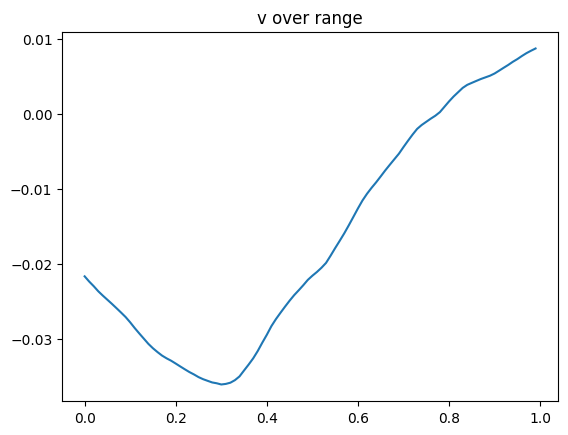

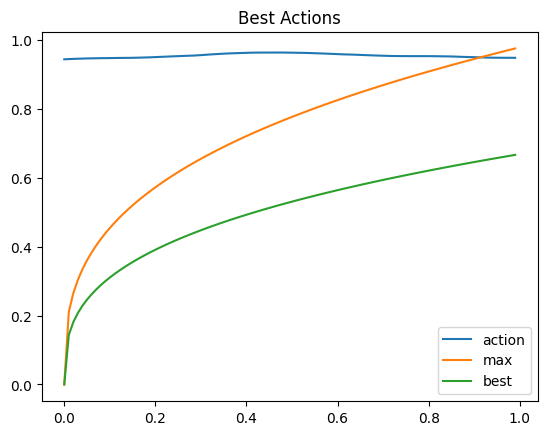

Step 0 utility -29.644172272309937
Episode 0 utility -29.644172272309937 convergence 3.636192147382644e-08 completed value error 0.9796534776687622 euler error 147.7074112453716


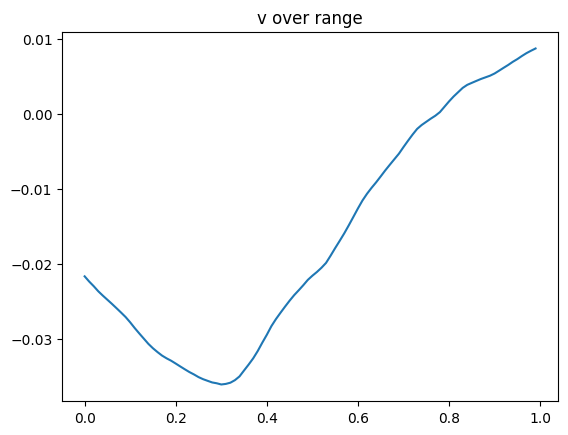

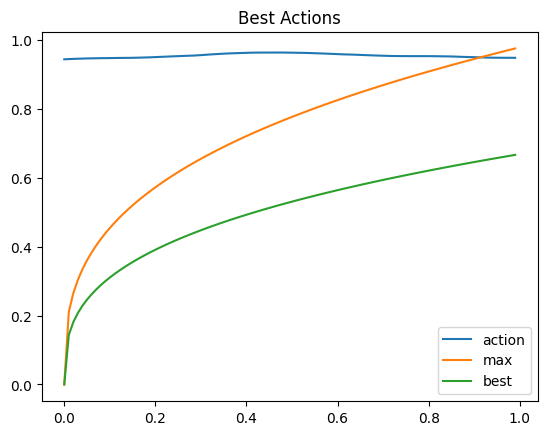

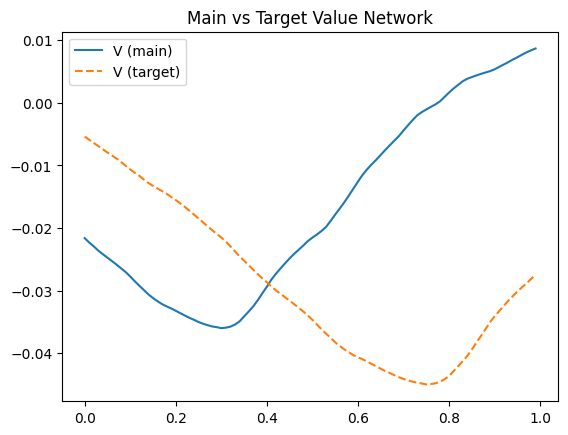

Step 10 utility -28.21937804206802
Step 20 utility -27.30993617355636
Step 30 utility -25.56157613868167
Step 40 utility -25.73271980127216
Step 50 utility -27.45914830592812
Episode 50 utility -27.45914830592812 convergence 0.024315567687153816 completed value error 1.070775032043457 euler error 144.2035193509169


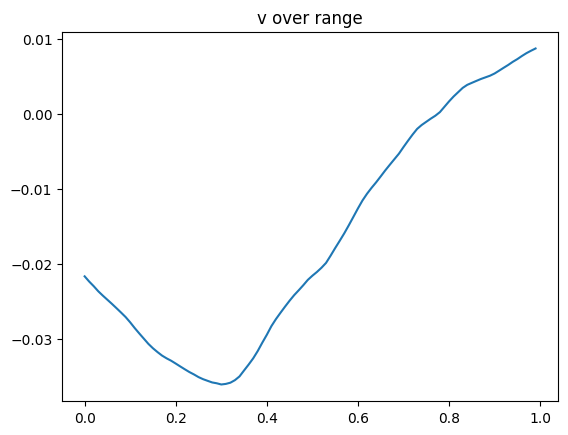

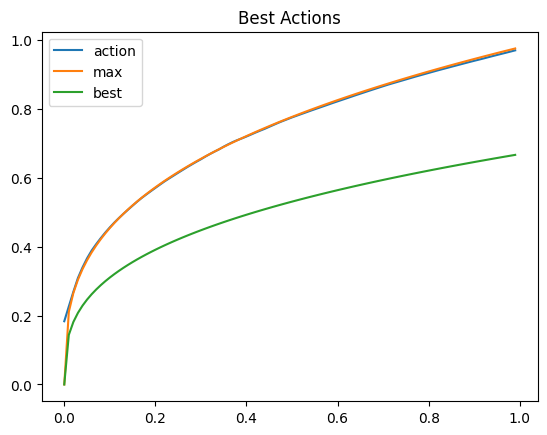

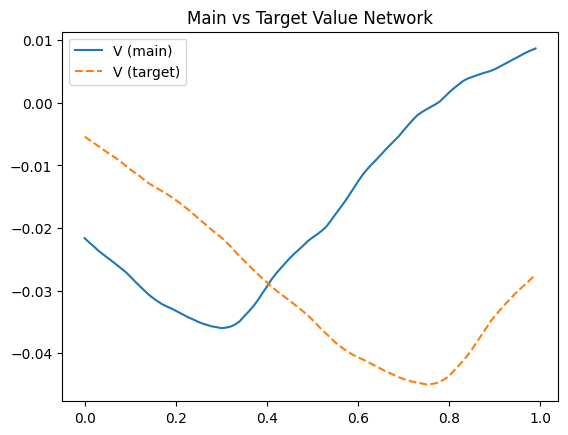

Step 60 utility -28.31077916259794
Step 70 utility -26.409035160898924
Step 80 utility -25.67819263271922
Step 90 utility -27.516721419886785
Step 100 utility -24.988807266952527
Episode 100 utility -24.988807266952527 convergence 0.03336440771818161 completed value error 1.6065411567687988 euler error 149.23811251988502


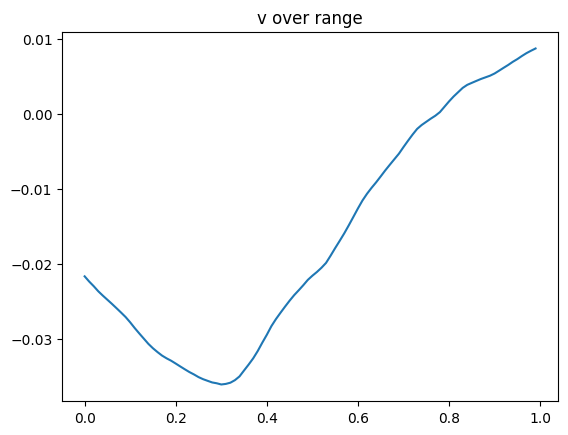

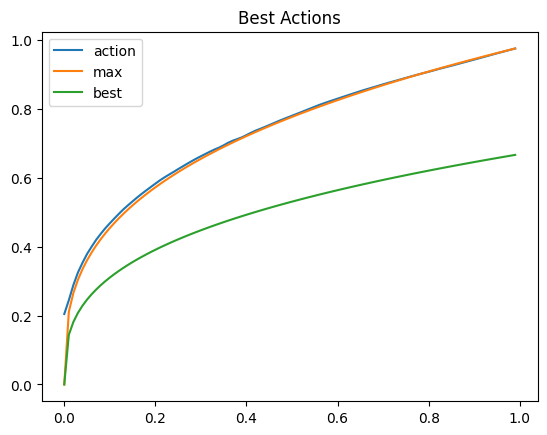

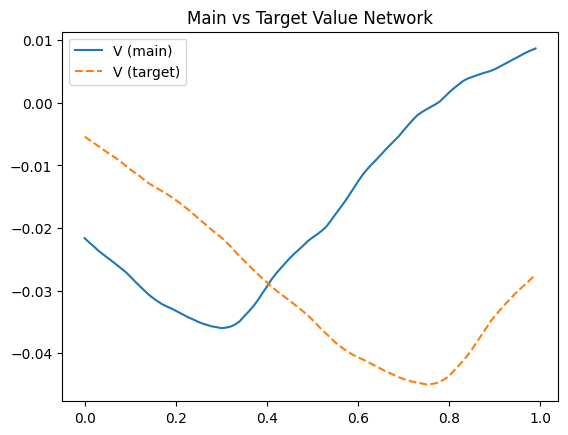

Step 110 utility -24.510632965449084
Step 120 utility -25.904725892700043
Step 130 utility -25.278592960834203
Step 140 utility -28.391063955235296
Step 150 utility -25.429653873622147
Episode 150 utility -25.429653873622147 convergence 0.017093610018491745 completed value error 1.126599907875061 euler error 148.59253342024886


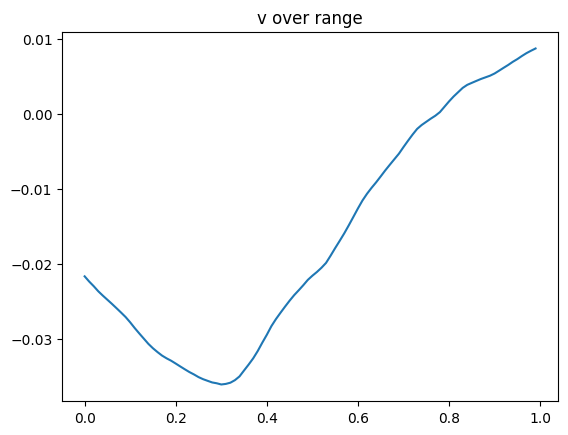

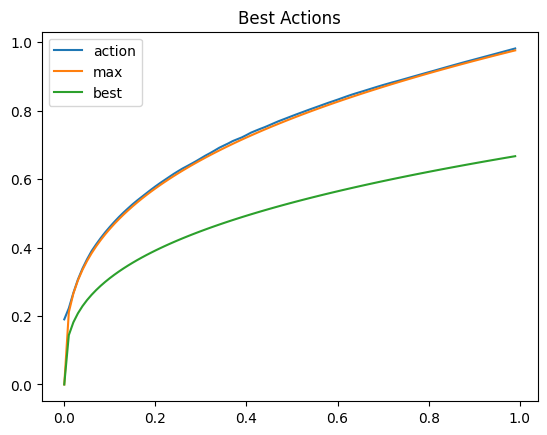

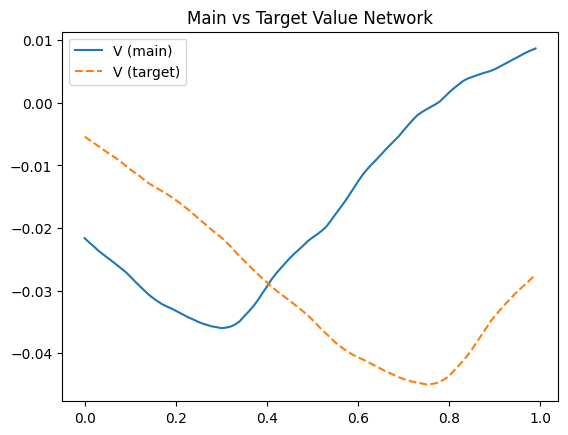

In [24]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-3,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': False, 'coldstart_actor': False}

import train_rl
model = train_rl.run(**params)

In [11]:
print(diagnostics.euler_error(model, jesusfv, 500, {'k': .1, 'z': 0}, clip=True, debug=False))

0.13564776228833011
